# Предсказание возраста покупателей по фото

Наш заказчик, сетевой супермаркет, просит нас построить модель для определения приблизительного возраста человека по фото. 

В нашем распоряжении набор фотографий людей с указанием возраста.

В качестве метрики будем использовать MAE.

---
Выполним импорт библиотек:

In [1]:
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

warnings.simplefilter(action='ignore', category=FutureWarning)

## Исследовательский анализ данных

### Загрузка данных и первичный анализ

Загрузим датафрейм с названиями файлов и лейблом.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

Проведём первичный анализ. 
Как выглядит датафрейм:

In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Размер выборки:

In [4]:
labels.shape

(7591, 2)

Есть ли пропуски в данных?

In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Итак, мы имеем практически 7600 фото людей разных возрастов. Если мы представим диапазон от 1 до 100 лет и условие - 100 фото на каждый год возраста, то нашего датасета явно не достаточно для обучения модели. В особенности, если мы взглянем ниже на график распределения возрастов, то увидим, что возраст распределён неравномерно и некоторые возраста имеют гораздо больше, чем 100 фото, а некоторые - гораздо меньше. Для повышения эффективности нашей будущей модели мы можем порекомендовать увеличить размер датасета минимум на четверть и добиться более плавного распределения возрастов.

Посмотрим на основные статистики выборки:

In [6]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


### График распределения возрастов

Построим график распределения возрастов, чтобы лучше понимать характер данных.

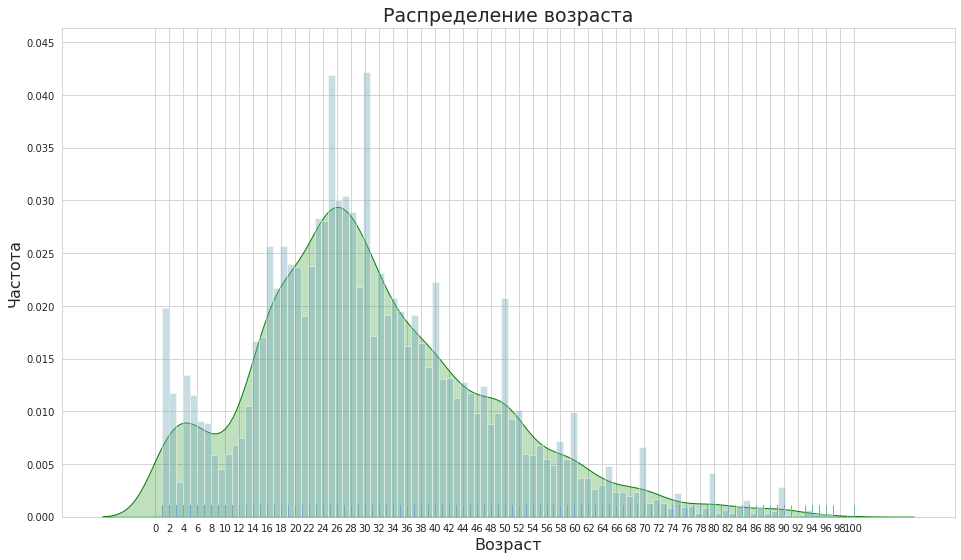

In [7]:
plt.figure(figsize=(16,9))
sns.set_style('whitegrid')
sns.set_palette('blend:#7AB,#EDA')
sns.distplot(labels['real_age'], rug=True, kde_kws={'shade':True, 'color':'g'}, bins=100)
plt.xlabel('Возраст', fontsize=16)
plt.ylabel('Частота', fontsize=16)
plt.xticks(np.arange(0, 102, 2))
plt.yticks(np.arange(0, 0.046, 0.005))
plt.title('Распределение возраста', fontsize=19)
plt.show()

Как мы видим, возраст распределён неравномерно. Можно заметить, что при подготовке датасета, особое внимание уделялось "десяткам" лет, начиная с 30: мы видим характерные пики на 30, 40, 50, 60, 70, 80, 90.

### Примеры фотографий 

Создадим генератор для наших фото.

In [8]:
example_datagen = ImageDataGenerator(rescale=1./255)
example_gen_flow = example_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=42) 

Found 7591 validated image filenames.


Проитерируем генератор для получения примеров фото.

In [9]:
features, target = next(example_gen_flow)

Визуализируем набор фотографий из итерации:

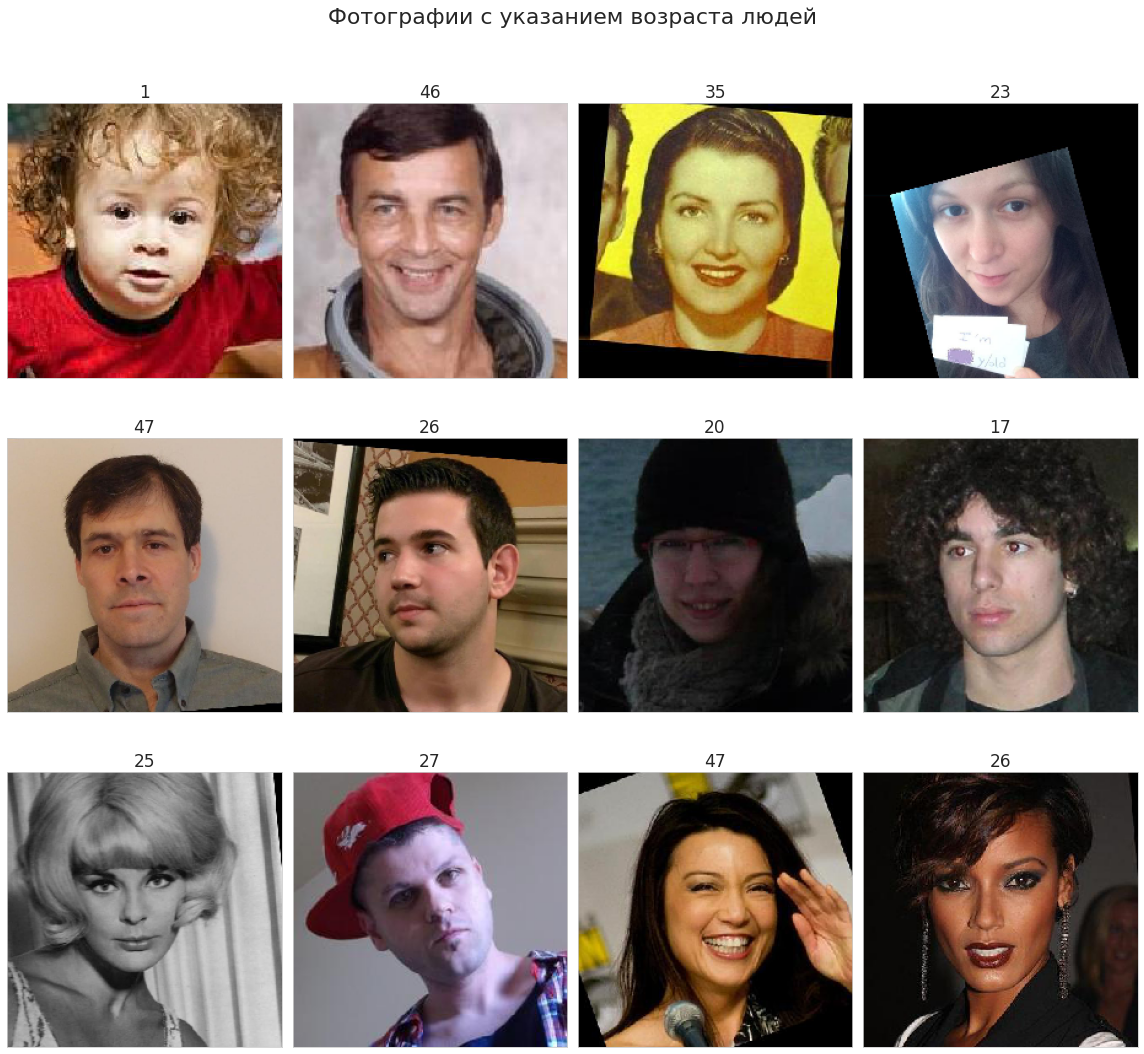

In [10]:
fig = plt.figure(figsize=(16,16))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'{target[i]}', fontsize=17)
    plt.xticks([])
    plt.yticks([])
    plt.suptitle('Фотографии с указанием возраста людей', fontsize=22)
    plt.tight_layout()

---
**Вывод:** завершив этап исследовательского анализа данных, можно утверждать, что
- данные не нуждаются в предварительной обработке - пропусков не обнаружено;
- мы имеем практически 7600 фото людей разных возрастов. Если мы представим диапазон от 1 до 100 лет и условие - 100 фото на каждый год возраста, то нашего датасета явно не достаточно для обучения модели. В особенности, если мы взглянем ниже на график распределения возрастов, то увидим, что возраст распределён неравномерно и некоторые возраста имеют гораздо больше, чем 100 фото, а некоторые - гораздо меньше. Для повышения эффективности нашей будущей модели мы можем порекомендовать увеличить размер датасета минимум на четверть и добиться более плавного распределения возрастов;
- чуть меньше четверти фото соответствуют критерию <18 лет, причём больше половины из этой четверти - фото детей возраста 1-10 лет; это может отразиться на качестве обучения модели, поскольку данных по возрастной группе 10-17 лет всего около 10% от общего размера выборки; также, мы имеем <5% фото для возрастной группы "больше 60 лет" - этот дефицит данных тоже скажется на качестве нашей модели;
- данные были специальным образом подготовлены - мы имеем разные показатели яркости, смещений и поворотов фотографий для центрирования и выравнивания лиц людей; имеет смысл аугментировать изображения при обучении модели - хотя бы отражением по горизонтали.

## Обучение модели

Здесь представлен код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается на отдельном GPU-сервере, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam


def load_train(path):
    
    '''
    Загружаем данные для обучения
    '''
    
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(validation_split=0.2,
                                       rescale=1/255,
                                       horizontal_flip=True)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=42)

    return train_gen_flow


def load_test(path):
    
    '''
    Загружаем тестовые данные
    '''
    
    labels = pd.read_csv(path + 'labels.csv')
    
    validation_datagen = ImageDataGenerator(validation_split=0.2, rescale=1/255)
    
    test_gen_flow = validation_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',  
        target_size=(224, 224), 
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42)

    return test_gen_flow


def create_model(input_shape):
    
    '''
    Создаём модель на основе ResNet50
    '''
    
    backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)
    
    model = Sequential()
    model.add(backbone)
    
    # Добавляем DropOut, поскольку модель легко переобучается
    model.add(Dropout(0.22))
    model.add(GlobalAveragePooling2D())
    
    # Выходной слой с 1 нейроном для регрессии
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(lr=0.00008)
    
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
    
    print(model.summary())
    
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
               steps_per_epoch=None, validation_steps=None):

    '''
    Обучаем нашу модель
    '''
    
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)  

    return model 



```

Результаты вывода на экран в ходе обучения модели:

```

Found 6073 validated image filenames.
Found 1518 validated image filenames.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
=================================================================
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
None
<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 190 steps, validate for 48 steps
Epoch 1/20
190/190 - 58s - loss: 247.5193 - mae: 11.2714 - val_loss: 1103.6836 - val_mae: 28.5786
Epoch 2/20
190/190 - 51s - loss: 74.8000 - mae: 6.5725 - val_loss: 800.2481 - val_mae: 23.0690
Epoch 3/20
190/190 - 50s - loss: 48.4825 - mae: 5.3573 - val_loss: 337.6245 - val_mae: 13.2103
Epoch 4/20
190/190 - 50s - loss: 33.5480 - mae: 4.4197 - val_loss: 124.4424 - val_mae: 8.1408
Epoch 5/20
190/190 - 48s - loss: 27.0588 - mae: 3.9630 - val_loss: 74.6738 - val_mae: 6.4255
Epoch 6/20
190/190 - 47s - loss: 22.3344 - mae: 3.5913 - val_loss: 79.5365 - val_mae: 6.5408
Epoch 7/20
190/190 - 49s - loss: 18.4120 - mae: 3.2896 - val_loss: 80.6200 - val_mae: 6.9038
Epoch 8/20
190/190 - 51s - loss: 13.9283 - mae: 2.8575 - val_loss: 73.5520 - val_mae: 6.3491
Epoch 9/20
190/190 - 49s - loss: 12.5212 - mae: 2.6818 - val_loss: 66.5359 - val_mae: 6.1431
Epoch 10/20
190/190 - 50s - loss: 11.0475 - mae: 2.5116 - val_loss: 63.4234 - val_mae: 5.8916
Epoch 11/20
190/190 - 47s - loss: 10.3326 - mae: 2.4493 - val_loss: 60.3329 - val_mae: 5.7912
Epoch 12/20
190/190 - 49s - loss: 9.0823 - mae: 2.2498 - val_loss: 60.6852 - val_mae: 5.8610
Epoch 13/20
Epoch 14/20
190/190 - 49s - loss: 8.6904 - mae: 2.2150 - val_loss: 69.7325 - val_mae: 6.1489
190/190 - 49s - loss: 7.5108 - mae: 2.0636 - val_loss: 60.4010 - val_mae: 5.7741
Epoch 15/20
190/190 - 50s - loss: 7.0420 - mae: 1.9879 - val_loss: 65.6684 - val_mae: 6.1591
Epoch 16/20
190/190 - 44s - loss: 6.8962 - mae: 1.9759 - val_loss: 60.9788 - val_mae: 5.9134
Epoch 17/20
190/190 - 41s - loss: 6.7854 - mae: 2.0051 - val_loss: 64.5604 - val_mae: 5.9752
Epoch 18/20
190/190 - 42s - loss: 6.9662 - mae: 2.0075 - val_loss: 60.6846 - val_mae: 5.7549
Epoch 19/20
190/190 - 48s - loss: 6.7801 - mae: 1.9566 - val_loss: 61.7331 - val_mae: 5.7375
Epoch 20/20
190/190 - 49s - loss: 6.7650 - mae: 1.9620 - val_loss: 62.0535 - val_mae: 5.7651
48/48 - 9s - loss: 62.0535 - mae: 5.7651
Test MAE: 5.7651

```

---
**Вывод:** завершив этап обучения модели, мы
- разбили данные на обучающую и тестовую выборку в соотношении 80-20;
- в качестве архитектуры сети выбрали модель ResNet без "верхушки", в качестве "верхушки" мы использовали слои Dropout, GlobalAveragePooling2D и полносвязный слой с 1 нейроном для регресии;
- в качестве функции потерь мы будем использовать MSE, а в качестве метрики - МАЕ;
- по итогам обучения, мы получили MAE, равное 5.77 на тестовом наборе данных.

## Анализ обученной модели

Мы получили МАЕ, равное 5.77 для скорости обучения 0.00008 и количества эпох, равное 20. 

Также, рекомендуем провести испытание модели на разных возрастных группах, чтобы понять, за счёт ошибок в какой группе мы получаем такое МАЕ. Может быть и такой исход - наша модель плохо предсказывает возраст для группы ">60 лет", из-за дефицита данных, а возрастную категорию "<18 лет" определяет хорошо - тогда мы добились поставленной цели.

Анализируя вывод на экран (в ходе обучения модели), можно утверждать, что начиная с 16ой эпохи наша модель перестала уменьшать потери на обучающей выборке. Видимо, был достигнут "предел" для нашей скорости обучения. Веса нейронной сети всё ещё продолжали изменяться, но тестовая МАЕ, равная 5.7 для наших гиперпараметров обучения - предел.


Это не первый запуск обучения модели, в нашем проекте не представлены попытки со скоростью обучения выше 0.0001. Для них характерны куда большие значения MAE, для скорости обучения 0.00016 - 6.15, 0.00022 - 6.63, для 0.00042 - 6.98.


Если есть необходимость добиться еще более низкой MAE, имеет смысл попробовать уменьшить скорость обучения в 2 раза, в диапазоне от 0.00002-0.00004 и оставить такое же количество эпох - 20, или сделать чуть больше.

## Общий вывод

Отвечая на главный вопрос проекта - предлагаем использовать обученную нами модель на основе ResNet для определения возраста покупателей, она показывает **значение МАЕ, равное 5.77**. 

В целом, в ходе проекта мы:

- завершив этап исследовательского анализа данных, можно утверждать, что
    - данные не нуждаются в предварительной обработке - пропусков не обнаружено;
    - мы имеем практически 7600 фото людей разных возрастов. Если мы представим диапазон от 1 до 100 лет и условие - 100 фото на каждый год возраста, то нашего датасета явно не достаточно для обучения модели. В особенности, если мы взглянем ниже на график распределения возрастов, то увидим, что возраст распределён неравномерно и некоторые возраста имеют гораздо больше, чем 100 фото, а некоторые - гораздо меньше. Для повышения эффективности нашей будущей модели мы можем порекомендовать увеличить размер датасета минимум на четверть и добиться более плавного распределения возрастов;
    - чуть меньше четверти фото соответствуют критерию <18 лет, причём больше половины из этой четверти - фото детей возраста 1-10 лет; это может отразиться на качестве обучения модели, поскольку данных по возрастной группе 10-17 лет всего около 10% от общего размера выборки; также, мы имеем <5% фото для возрастной группы "больше 60 лет" - этот дефицит данных тоже скажется на качестве нашей модели;
    - данные были специальным образом подготовлены - мы имеем разные показатели яркости, смещений и поворотов фотографий для центрирования и выравнивания лиц людей; имеет смысл аугментировать изображения при обучении модели - хотя бы отражением по горизонтали.
    
    
- завершив этап обучения модели, мы
    - разбили данные на обучающую и тестовую выборку в соотношении 80-20;
    - в качестве архитектуры сети выбрали модель ResNet без "верхушки", в качестве "верхушки" мы использовали слои Dropout, GlobalAveragePooling2D и полносвязный слой с 1 нейроном для регресии;
    - в качестве функции потерь мы будем использовать MSE, а в качестве метрики - МАЕ;
    - по итогам обучения, мы получили MAE, равное 5.77 на тестовом наборе данных.
    
    
- завершив этап анализа обученной модели, мы

    - получили МАЕ, равное 5.77 для скорости обучения 0.00008 и количества эпох, равное 20;

    - рекомендуем провести испытание модели на разных возрастных группах, чтобы понять, за счёт ошибок в какой группе мы получаем такое МАЕ. Может быть и такой исход - наша модель плохо предсказывает возраст для группы ">60 лет", из-за дефицита данных, а возрастную категорию "<18 лет" определяет хорошо - тогда мы добились поставленной цели.